<a href="https://colab.research.google.com/github/mihneacoman/Sentiment-Analysis-IMDB-reviews/blob/main/Sentiment_Analysis_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

---




**Importing the csv file and renaming the columns.**

---

---





In [ ]:
import numpy as np
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/Proiect IMDB/"
df = pd.read_csv(path+'IMDB Dataset.csv')

Mounted at /content/drive


Importing the required libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from bs4 import BeautifulSoup
from nltk.corpus import wordnet as wn
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = df.rename(columns={'review': 'text'})
df['sentiment'] = df['sentiment'].map({'negative':-1,'positive':1})
df

,text,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,-1
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",-1
49997,I am a Catholic taught in parochial elementary...,-1
49998,I'm going to have to disagree with the previou...,-1




---


---


**Choosing a random sample of2000 **

---


---





In [ ]:
print(df['sentiment'].value_counts())

# Impart setul de date dupa sentiment (negativ si pozitiv)
df_negative = df[df['sentiment'] == -1]
df_positive = df[df['sentiment'] == 1]

min_samples = 2000

# Selectam random 2000 de exemple din fiecare sentiment
df_negative_sampled = df_negative.sample(n=min_samples)
df_positive_sampled = df_positive.sample(n=min_samples)

# Le combinam intr-un singur dataframe
df_sampled = pd.concat([df_negative_sampled, df_positive_sampled])

# Amestecam randurile
df_sampled = df_sampled.sample(frac=1).reset_index(drop=True)

print(df_sampled['sentiment'].value_counts())

df_sampled


sentiment
 1    25000
-1    25000
Name: count, dtype: int64
sentiment
-1    2000
 1    2000
Name: count, dtype: int64


,text,sentiment
0,I will confess that once I started watching th...,-1
1,Cuba Gooding Jr. and Ed Harris are touching. T...,1
2,I viewed this movie for the first time last ni...,1
3,trying hard to fit into the scary space comedy...,-1
4,This movie is a gem! It is the story of Juliet...,1
...,...,...
3995,Disney has now made straight-to-video sequels ...,-1
3996,I firmly believe that the best Oscar ceremony ...,-1
3997,"One of my favorite movies. Great cast, lead by...",1
3998,"God cuts himself with a straight razor, afterw...",1




---



---
**Analiza setului de date**


---



---




<Axes: xlabel='sentiment'>

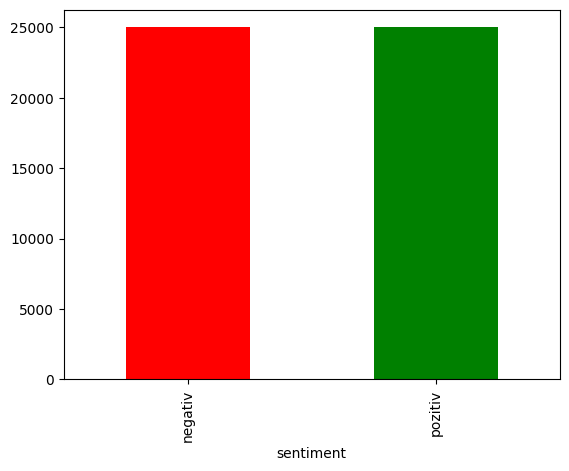

In [ ]:
label_map = {-1: "negativ", 1: "pozitiv"}
sentiment_counts = df["sentiment"].value_counts().sort_index()
sentiment_counts.index = sentiment_counts.index.map(label_map)
sentiment_counts.plot(kind="bar", color=["red", "green"])

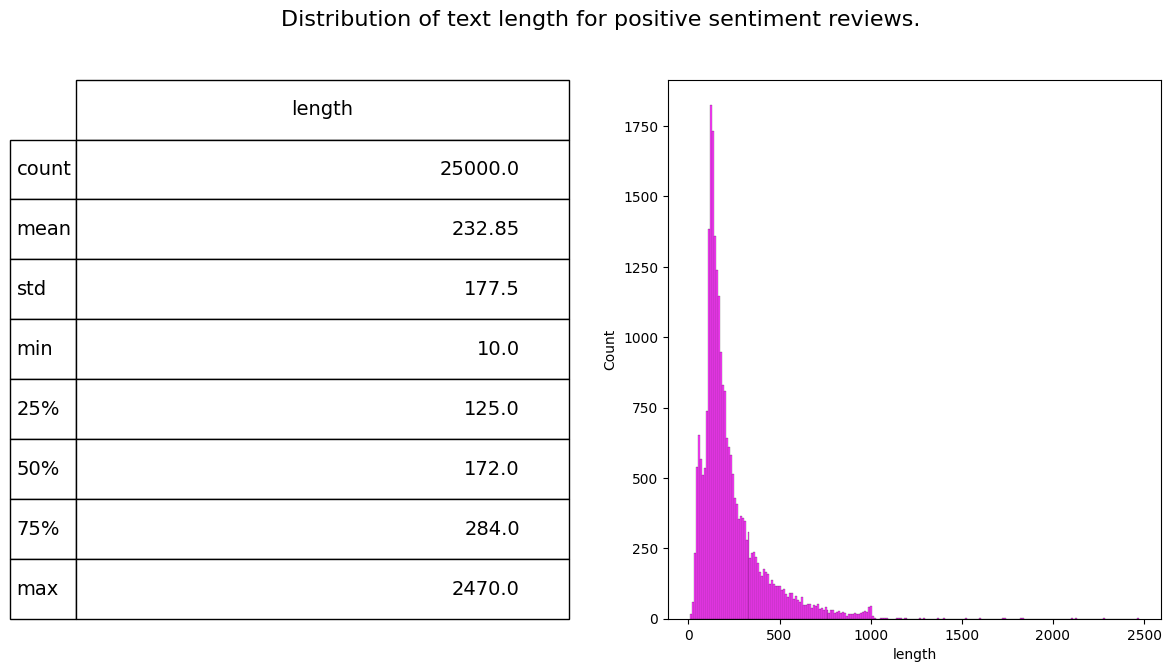

In [ ]:
import seaborn as sns

review_len = pd.Series([len(review.split()) for review in df['text']])

fig = plt.figure(figsize=(14,7))
df['length'] = df.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']==1]['length'], ax=ax1,color='magenta')
describe = df.length[df.sentiment==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment reviews.', fontsize=16)

plt.show()

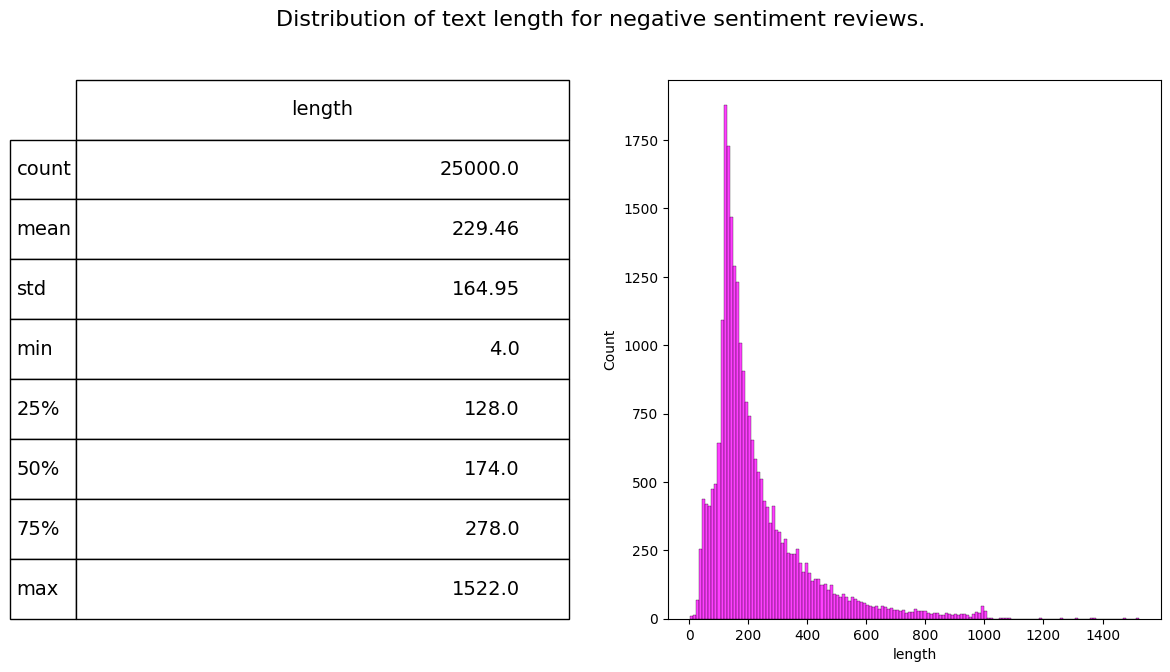

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']==-1]['length'], ax=ax1,color='magenta')
describe = df.length[df.sentiment==-1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment reviews.', fontsize=16)

plt.show()



---



---


**TF_IDF vectorization and logistic regression**


---



---



In [ ]:
# loading the spacy model for tokenization
nlp = spacy.load("en_core_web_sm")

lemmatizer = WordNetLemmatizer()

# list of common negations (we wish to keep them)
negations = {"not", "no", "n't", "isn't", "aren't", "won't", "can't", "never", "nothing"}

def review_to_words(review):

    # removing HTML tags and hashtags
    review = re.sub(r"<.*?>", " ", review)
    review = re.sub(r"(@[A-Za-z0-9_]+)|(#\S+)", " ", review)

    doc = nlp(review.lower())

    clean_tokens = []
    for token in doc:
        # removing punctuation, spaces and stopwords (excluding negations)
        if token.is_punct or token.is_space:
            continue
        if token.is_stop and token.text not in negations:
            continue
        # lematizare
        clean_tokens.append(token.lemma_)

    return clean_tokens

df_sampled['processed_text'] = df_sampled['text'].apply(review_to_words)

# checking that preprocessing worked
print(df_sampled[['text', 'processed_text']].head())

#transforming tokens into strings
df_sampled['processed_text'] = df_sampled['processed_text'].apply(lambda tokens: ' '.join(tokens))

#splitting the dataset
X_text_train, X_text_test, y_train, y_test = train_test_split(df_sampled['processed_text'], df_sampled['sentiment'], test_size=0.3)

# vectorization of X_train and X_test
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_text_train)

X_test = vectorizer.transform(X_text_test)

# training the Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0)
model.fit(X_train, y_train)

# predictions and evaluation
y_pred_lr = model.predict(X_test)
y_true_lr = y_test
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

                                                text  \
0  I will confess that once I started watching th...   
1  Cuba Gooding Jr. and Ed Harris are touching. T...   
2  I viewed this movie for the first time last ni...   
3  trying hard to fit into the scary space comedy...   
4  This movie is a gem! It is the story of Juliet...   

                                      processed_text  
0  [confess, start, watch, movie, hold, force, wa...  
1  [cuba, gooding, jr, ed, harris, touch, movie, ...  
2  [view, movie, time, night, enjoy, aspect, the...  
3  [try, hard, fit, scary, space, comedy, genre, ...  
4  [movie, gem, story, juliette, perfectly, ordin...  
Accuracy: 0.83

Classification Report:
               precision    recall  f1-score   support

          -1       0.85      0.79      0.82       587
           1       0.81      0.87      0.84       613

    accuracy                           0.83      1200
   macro avg       0.83      0.83      0.83      1200
weighted avg       0.



---



---



**Verifying a new review.**


---



---



In [ ]:
new_text = "I did not enjoy this movie"
print(f"The review is: {new_text}")
tokens = review_to_words(new_text)
prop = ' '.join(tokens)

X_new = vectorizer.transform([prop])

y_pred_new = model.predict(X_new)

print("Preprocessed review:", prop)
print("Prediction for this review:", y_pred_new)

Review-ul este: I did not enjoy this movie
Review preprocesat: not enjoy movie
Predicția pentru acest review: [1]




---

False positives and false negatives


---



In [ ]:
# resetting the index to match X_test
df_test = df_sampled.iloc[y_test.index].copy()
df_test["true_label"] = y_test.values
df_test["predicted_label"] = y_pred_lr

# false positives:
false_positives = df_test[(df_test["true_label"] == -1) & (df_test["predicted_label"] == 1)]

# false negatives:
false_negatives = df_test[(df_test["true_label"] == 1) & (df_test["predicted_label"] == -1)]

# printing a few examples
print("FALSE POSITIVES (predicted 1, true -1):")
print(false_positives[["text", "true_label", "predicted_label"]].head(5))

print("\nFALSE NEGATIVES (predicted -1, true 1):")
print(false_negatives[["text", "true_label", "predicted_label"]].head(5))
#pd.set_option("display.max_colwidth", None)

FALSE POSITIVES (predicted 1, true -1):
                                                   text  true_label  \
1732  there was some truth to this movie. I remember...          -1   
3739  I loved so much last Bellocchio's movie, the m...          -1   
1499  Dewaana as a film goes through the usual clich...          -1   
1722  This is a story of a Jewish dysfunctional fami...          -1   
3828  This film concerns the story of Eddy as mentio...          -1   

      predicted_label  
1732                1  
3739                1  
1499                1  
1722                1  
3828                1  

FALSE NEGATIVES (predicted -1, true 1):
                                                   text  true_label  \
3643  If you like CB4, you have no idea what you're ...           1   
2057  When I saw the preview for this movie, I figur...           1   
2641  The Beatles had just done 'Magical Mystery Tou...           1   
2776  Nazarin is some kind of saint,he wants to live...         

Handling negations.

In [ ]:
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

#function that replaces negated words with their antonyms
def Negation(sentence):

    i = 1
    while i < len(sentence):
        if sentence[i-1] in ['not', "n't"]:
            antonyms = []

            for syn in wn.synsets(sentence[i]):
                for lemma in syn.lemmas():
                    if lemma.antonyms():
                        antonyms.append(lemma.antonyms()[0].name())

            if 'bad' in antonyms:
                sentence[i] = 'bad'
            elif antonyms:
                sentence[i] = antonyms[0]
            sentence[i-1] = ''
        i += 1

    return ' '.join([word for word in sentence if word])

df_sampled = df_sampled.drop('processed_text', axis=1)

df_sampled['processed_text'] = df_sampled['text'].apply(review_to_words)
df_sampled['processed_text'] = df_sampled['processed_text'].apply(Negation)

X_text_train, X_text_test, y_train, y_test = train_test_split(df_sampled['processed_text'], df_sampled['sentiment'], test_size=0.3)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_text_train)

X_test = vectorizer.transform(X_text_test)

# training the new model (that handles negations)
model = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0)
model.fit(X_train, y_train)

# evaluation
y_pred_lr = model.predict(X_test)
y_true_lr = y_test
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

Accuracy: 0.8491666666666666

Classification Report:
               precision    recall  f1-score   support

          -1       0.85      0.84      0.84       582
           1       0.85      0.86      0.85       618

    accuracy                           0.85      1200
   macro avg       0.85      0.85      0.85      1200
weighted avg       0.85      0.85      0.85      1200



Bag of Words + Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

X_text_train_bow, X_text_test_bow, y_train_bow, y_test_bow = train_test_split(df_sampled['processed_text'], df_sampled['sentiment'], test_size=0.3)

vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_bow = vectorizer.fit_transform(X_text_train_bow)

X_test_bow = vectorizer.transform(X_text_test_bow)

model = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0)
model.fit(X_train_bow, y_train_bow)

y_pred_bow = model.predict(X_test_bow)
y_true_bow = y_test_bow
print("Accuracy:", accuracy_score(y_test_bow, y_pred_bow))
print("\nClassification Report:\n", classification_report(y_test_bow, y_pred_bow))

Accuracy: 0.8183333333333334

Classification Report:
               precision    recall  f1-score   support

          -1       0.81      0.81      0.81       578
           1       0.83      0.82      0.82       622

    accuracy                           0.82      1200
   macro avg       0.82      0.82      0.82      1200
weighted avg       0.82      0.82      0.82      1200



TF-IDF + Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

X_text_train_nb, X_text_test_nb, y_train_nb, y_test_nb = train_test_split(df_sampled['processed_text'], df_sampled['sentiment'], test_size=0.3)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_nb = vectorizer.fit_transform(X_text_train_nb)

X_test_nb = vectorizer.transform(X_text_test_nb)

model = MultinomialNB()
model.fit(X_train_nb, y_train_nb)

y_pred_nb = model.predict(X_test_nb)
y_true_nb = y_test_nb
print("Accuracy:", accuracy_score(y_test_nb, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test_nb, y_pred_nb))

Accuracy: 0.8383333333333334

Classification Report:
               precision    recall  f1-score   support

          -1       0.84      0.83      0.83       591
           1       0.84      0.85      0.84       609

    accuracy                           0.84      1200
   macro avg       0.84      0.84      0.84      1200
weighted avg       0.84      0.84      0.84      1200



BoW cu Naive Bayes

In [ ]:
X_text_train_nb, X_text_test_nb, y_train_nb, y_test_nb = train_test_split(df_sampled['processed_text'], df_sampled['sentiment'], test_size=0.3)

vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_nb = vectorizer.fit_transform(X_text_train_nb)

X_test_nb = vectorizer.transform(X_text_test_nb)

model = MultinomialNB()
model.fit(X_train_nb, y_train_nb)

y_pred_nb = model.predict(X_test_nb)
y_true_nb = y_test_nb
print("Accuracy:", accuracy_score(y_test_nb, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test_nb, y_pred_nb))

Accuracy: 0.8158333333333333

Classification Report:
               precision    recall  f1-score   support

          -1       0.83      0.81      0.82       621
           1       0.80      0.82      0.81       579

    accuracy                           0.82      1200
   macro avg       0.82      0.82      0.82      1200
weighted avg       0.82      0.82      0.82      1200



Vectorization using Word2Vec weighted with TFIDF on our dataset.

In [ ]:
!pip install gensim

In [ ]:
!pip uninstall -y numpy gensim
!pip install numpy gensim

In [ ]:
!pip install numpy==2.0.0

In [ ]:
!pip install --upgrade gensim numpy

In [ ]:
from gensim.models import Word2Vec

tokenized_reviews = df_sampled['processed_text'].apply(lambda x: x.split())
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=7, min_count=1, sg=1)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(df_sampled['processed_text'])

def get_weighted_average_vector(text, model, vectorizer):
    words = text.split()
    tfidf_scores = vectorizer.transform([text]).toarray()[0]
    word_vectors = []

    for idx, word in enumerate(words):
        if word in model.wv:
            tfidf_score = tfidf_scores[vectorizer.vocabulary_.get(word, 0)]
            word_vectors.append(model.wv[word] * tfidf_score)  #ponderam vectorul cu scorul TF-IDF

    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# vectorization
X_vectors_tfidf_weighted = np.array([get_weighted_average_vector(text, w2v_model, vectorizer) for text in df_sampled['processed_text']])

# splitting the dataset
y = df_sampled['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X_vectors_tfidf_weighted, y, test_size=0.3)

# training with logistic regression
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# evaluation
y_pred_w2v = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_w2v))
print("\nClassification Report:\n", classification_report(y_test, y_pred_w2v))

In [ ]:
new_text = "I liked the movie"
tokens = review_to_words(new_text)
neg_handled = Negation(tokens)
X_new_weighted_vector = get_weighted_average_vector(neg_handled, w2v_model, vectorizer).reshape(1, -1)

y_pred_new = model.predict(X_new_weighted_vector)
print(y_pred_new)

Vectorization using Word2Vec pretrained on Google News.

In [ ]:
import gensim.downloader as api
from gensim.models import KeyedVectors

w2v_model = api.load("word2vec-google-news-300")

Training Word2Vec pretrained on Google News.

In [ ]:
def get_review_vector(text, model):
    words = text.split()
    word_vectors = [model[word] for word in words if word in model]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

X_vectors = np.array([get_review_vector(text, w2v_model) for text in df_sampled['processed_text']])
y = df_sampled['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X_vectors, y, test_size=0.3)

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred_w2vg = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_w2vg))
print("\nClassification Report:\n", classification_report(y_test, y_pred_w2vg))

Testing a new review.

In [ ]:
new_text = "The suffering of the family really touched me. I really related with their terrible living conditions, as I have been in such a tough spot myself. As such, I was really touched by the story."
tokens = review_to_words(new_text)
neg_handled = Negation(tokens)
vector = get_review_vector(neg_handled, w2v_model).reshape(1, -1)
print("Predicție:", model.predict(vector))



---



---


**Adding a dependency tree derived feature.**


---


---




In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    return text.lower()

# we extract SVO triplets
def extract_dependency_features(text):
    doc = nlp(text)
    triples = []
    for token in doc:
        if token.dep_ == "ROOT" and token.pos_ == "VERB":
            subject = [child for child in token.children if "subj" in child.dep_]
            obj = [child for child in token.children if "obj" in child.dep_ or "attr" in child.dep_]
            if subject and obj:
                s = subject[0].lemma_
                v = token.lemma_
                o = obj[0].lemma_
                triples.append(f"{s}_{v}_{o}")

    return " ".join(triples)

def preprocess_with_dependencies(text):
    text_clean = clean_text(text)
    tokens = text_clean.split()
    tokens_neg_handled = Negation(tokens)
    text_neg_handled = tokens_neg_handled
    text_lemmas = [lemmatizer.lemmatize(word) for word in text_neg_handled.split() if word not in stop_words]
    triple_features = extract_dependency_features(text_neg_handled)
    return " ".join(text_lemmas) + " " + triple_features

df_sampled['processed_text_tree'] = df_sampled['text'].apply(preprocess_with_dependencies)

X_train, X_test, y_train, y_test = train_test_split(df_sampled['processed_text_tree'], df_sampled['sentiment'], test_size=0.3)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0)
model.fit(X_train_vec, y_train)

# Predicții și metrice
y_pred_tree = model.predict(X_test_vec)
y_true_tree=y_test
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_tree))

Accuracy: 0.8425

Classification Report:

              precision    recall  f1-score   support

          -1       0.85      0.84      0.84       610
           1       0.83      0.85      0.84       590

    accuracy                           0.84      1200
   macro avg       0.84      0.84      0.84      1200
weighted avg       0.84      0.84      0.84      1200



In [ ]:
df_test_tree = df_sampled.iloc[y_test.index].copy()
df_test_tree["true_label"] = y_test.values
df_test_tree["predicted_label"] = y_pred_tree

# False positives
false_positives = df_test_tree[(df_test_tree["true_label"] == -1) & (df_test_tree["predicted_label"] == 1)]

# False negatives
false_negatives = df_test_tree[(df_test_tree["true_label"] == 1) & (df_test_tree["predicted_label"] == -1)]

# Printing a few examples
print("FALSE POSITIVES (predicted 1, true -1):")
print(false_positives[["text", "true_label", "predicted_label"]].head(5))

print("\nFALSE NEGATIVES (predicted -1, true 1):")
print(false_negatives[["text", "true_label", "predicted_label"]].head(5))

FALSE POSITIVES (predicted 1, true -1):
                                                   text  true_label  \
3635  When I saw this movie I heard all the hype, an...          -1   
3009  Bette Davis brings her full trunk of tics to t...          -1   
3255  I don't know what it is with these Brady kids....          -1   
1115  It's been mentioned by others the inane dialog...          -1   
686   This was the typical women prison movie. I tho...          -1   

      predicted_label  
3635                1  
3009                1  
3255                1  
1115                1  
686                 1  

FALSE NEGATIVES (predicted -1, true 1):
                                                   text  true_label  \
3373  I could not take my eyes off this movie when i...           1   
2788  It's become extremely difficult to find a good...           1   
817   Giallo fans, seek out this rare film. It is we...           1   
1209  Let's get some things straight first: Zombies ...         



---



---
Transformers


---



---




In [ ]:
!pip uninstall -y transformers
!pip install transformers datasets -q
from transformers import TrainingArguments
import transformers
print(transformers.__version__)

Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nv

In [ ]:
import os
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# desabling wandb (external logging)
os.environ["WANDB_DISABLED"] = "true"

# we need the labels to be 0 and 1
df_test_bert = df_sampled.copy()
df_test_bert['label'] = df_test_bert['sentiment'].map({-1: 0, 1: 1})

# train/test split
train_df, test_df = train_test_split(df_test_bert, test_size=0.2, stratify=df_test_bert['label'])

train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# model and data collator
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# hyperparameters
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

# trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# evaluation
preds_output = trainer.predict(test_dataset)
y_pred_bert = preds_output.predictions.argmax(-1)
y_true_bert = preds_output.label_ids

df_test_bert = test_df.copy()

df_test_bert["true_label"] = y_true_bert
df_test_bert["predicted_label"] = y_pred_bert

df_test_bert["true_label"] = df_test_bert["true_label"].map({0: -1, 1: 1})
df_test_bert["predicted_label"] = df_test_bert["predicted_label"].map({0: -1, 1: 1})

print("\nclassification report:")
print(classification_report(y_true_bert, y_pred_bert, target_names=["Negative", "Positive"]))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-20-a7073944a2d1>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,0.754200
20,0.571700
30,0.354300
40,0.977500
50,0.667000
60,0.403800
70,0.332000
80,0.573200
90,0.548100
100,0.382500



classification report:
              precision    recall  f1-score   support

    Negative       0.92      0.92      0.92       400
    Positive       0.92      0.92      0.92       400

    accuracy                           0.92       800
   macro avg       0.92      0.92      0.92       800
weighted avg       0.92      0.92      0.92       800



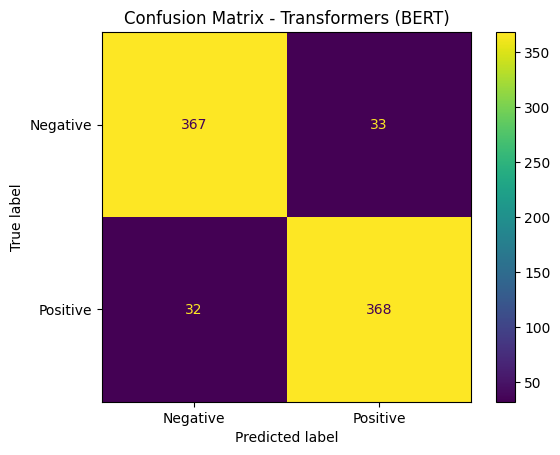

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_true_bert, y_pred_bert, display_labels=["Negative", "Positive"])
plt.title("Confusion Matrix - Transformers (BERT)")
plt.show()


Training loss plot.

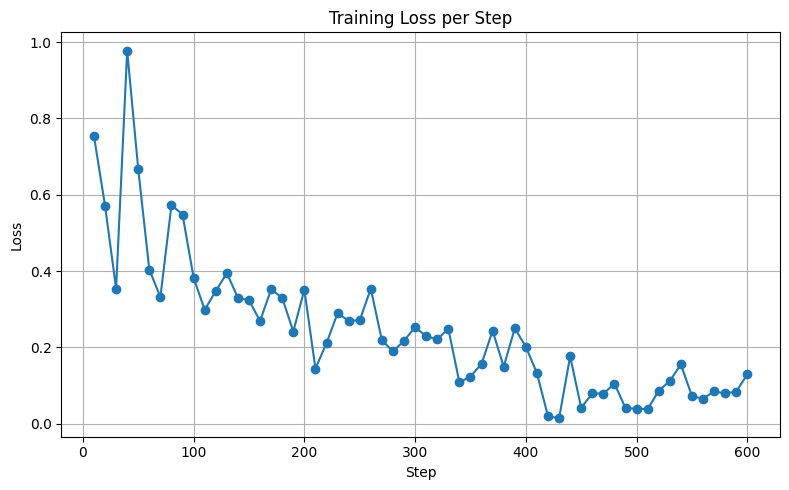

In [ ]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

steps = []
losses = []

for entry in log_history:
    if "loss" in entry and "epoch" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker='o')
plt.title("Training Loss per Step")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


---



**Comparing the models.**

---



In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

y_pred_lr = y_pred_lr.ravel()
y_pred_tree = y_pred_tree.ravel()
y_pred_bert = y_pred_bert.ravel()

report_lr = classification_report(y_true_lr, y_pred_lr, target_names=["Negative", "Positive"], output_dict=True)
report_tree = classification_report(y_true_tree, y_pred_tree, target_names=["Negative", "Positive"], output_dict=True)
report_bert = classification_report(y_true_bert, y_pred_bert, target_names=["Negative", "Positive"], output_dict=True)

def extract_metrics(report, model_name):
    rows = []
    for cls in ["Negative", "Positive"]:
        row = {
            "Model": model_name,
            "Class": cls,
            "Precision": round(report[cls]["precision"], 2),
            "Recall": round(report[cls]["recall"], 2),
            "F1-Score": round(report[cls]["f1-score"], 2),
            "Support": int(report[cls]["support"])
        }
        rows.append(row)
    return rows

data = []
data += extract_metrics(report_lr, "Logistic Regression")
data += extract_metrics(report_tree, "Dependency Tree")
data += extract_metrics(report_bert, "Transformers")

comparison_df = pd.DataFrame(data)

print(comparison_df)

                 Model     Class  Precision  Recall  F1-Score  Support
0  Logistic Regression  Negative       0.85    0.84      0.84      582
1  Logistic Regression  Positive       0.85    0.86      0.85      618
2      Dependency Tree  Negative       0.85    0.84      0.84      610
3      Dependency Tree  Positive       0.83    0.85      0.84      590
4         Transformers  Negative       0.92    0.92      0.92      400
5         Transformers  Positive       0.92    0.92      0.92      400


                 Model       Error Type  Count
0  Logistic Regression  False Positives    123
1  Logistic Regression  False Negatives     81
2      Dependency Tree  False Positives     99
3      Dependency Tree  False Negatives     90
4         Transformers  False Positives     33
5         Transformers  False Negatives     32


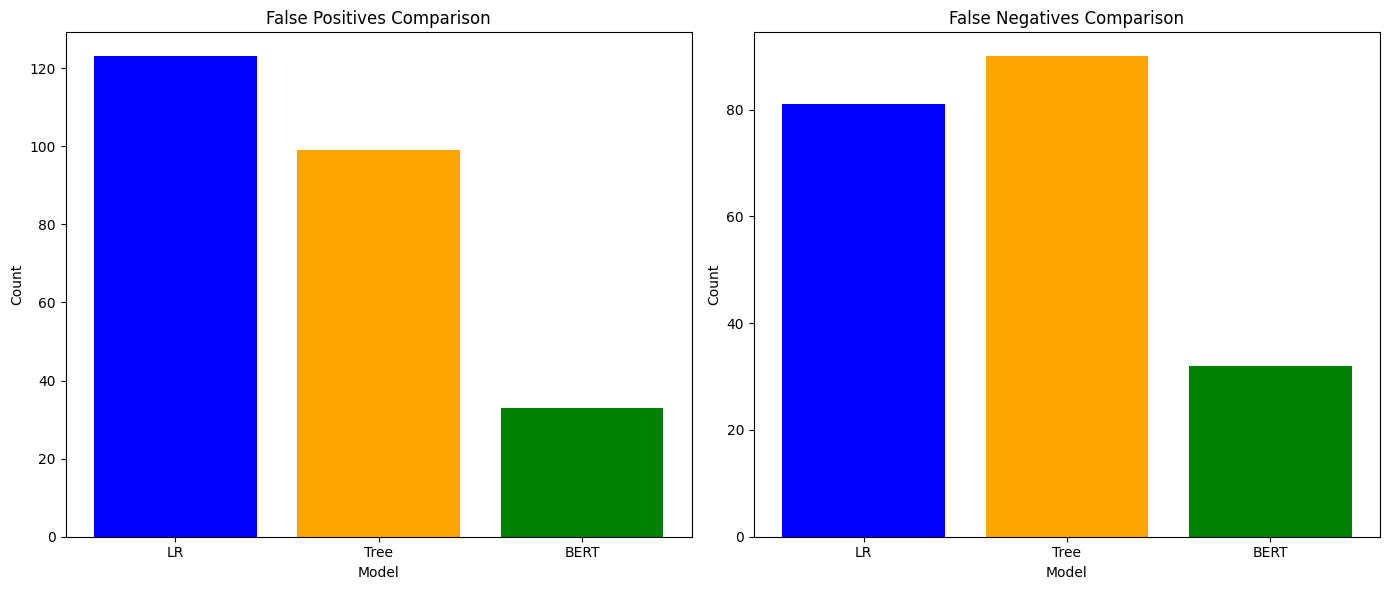

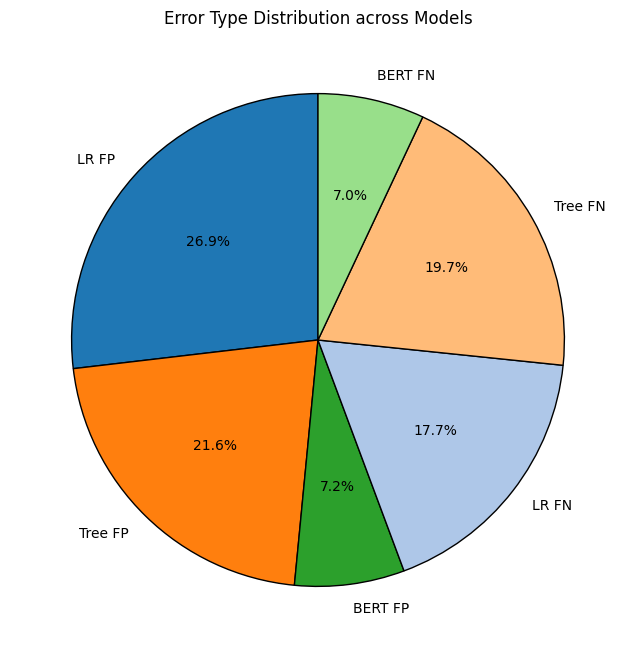

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

false_positives_lr = df_test[(df_test["true_label"] == -1) & (df_test["predicted_label"] == 1)]
false_negatives_lr = df_test[(df_test["true_label"] == 1) & (df_test["predicted_label"] == -1)]

false_positives_tree = df_test_tree[(df_test_tree["true_label"] == -1) & (df_test_tree["predicted_label"] == 1)]
false_negatives_tree = df_test_tree[(df_test_tree["true_label"] == 1) & (df_test_tree["predicted_label"] == -1)]

false_positives_bert = df_test_bert[(df_test_bert["true_label"] == -1) & (df_test_bert["predicted_label"] == 1)]
false_negatives_bert = df_test_bert[(df_test_bert["true_label"] == 1) & (df_test_bert["predicted_label"] == -1)]

#total number of errors
false_pos_lr_count = len(false_positives_lr)
false_neg_lr_count = len(false_negatives_lr)
false_pos_tree_count = len(false_positives_tree)
false_neg_tree_count = len(false_negatives_tree)
false_pos_bert_count = len(false_positives_bert)
false_neg_bert_count = len(false_negatives_bert)

# comparative dataframe
comparison_data = {
    "Model": ["Logistic Regression", "Logistic Regression",
              "Dependency Tree", "Dependency Tree",
              "Transformers", "Transformers"],
    "Error Type": ["False Positives", "False Negatives",
                   "False Positives", "False Negatives",
                   "False Positives", "False Negatives"],
    "Count": [false_pos_lr_count, false_neg_lr_count,
              false_pos_tree_count, false_neg_tree_count,
              false_pos_bert_count, false_neg_bert_count]
}

comparison_df = pd.DataFrame(comparison_data)

print(comparison_df)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(['LR', 'Tree', 'BERT'],
          [false_pos_lr_count, false_pos_tree_count, false_pos_bert_count],
          color=['blue', 'orange', 'green'])
ax[0].set_title("False Positives Comparison")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Model")

ax[1].bar(['LR', 'Tree', 'BERT'],
          [false_neg_lr_count, false_neg_tree_count, false_neg_bert_count],
          color=['blue', 'orange', 'green'])
ax[1].set_title("False Negatives Comparison")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Model")

plt.tight_layout()
plt.show()

# pie chart
labels = ['LR FP', 'Tree FP', 'BERT FP', 'LR FN', 'Tree FN', 'BERT FN']
sizes = [false_pos_lr_count, false_pos_tree_count, false_pos_bert_count,
         false_neg_lr_count, false_neg_tree_count, false_neg_bert_count]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#aec7e8', '#ffbb78', '#98df8a']

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
ax.set_title("Error Type Distribution across Models")
plt.show()